<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget


plt.rc('lines', linewidth=3.0, markersize=10.0)
plt.rc('text', usetex=True)

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10, 7))
plt.rc('figure', autolayout=True)

In [2]:
# Meus dados ab initio

L_BGW = [2.4, 4.4, 3.2, 3.2]
L_BGW = np.array(L_BGW)/np.sqrt(2)
Eb_BGW = [1.208, 0.816, 0.915, 0.902]

# PRB 74, 121401 (R) (2006)

def ntc_diam(n, m):
    a = 0.246 # nm
    return a*np.sqrt(n**2 + n*m + m**2)/np.pi

def eta_nm(n, m):  # (-1)^nu * cos(3*theta) / d | tan(theta) = sqrt(3)*m/(2*n+m)
    d = ntc_diam(n, m)
    nu = (2*n + m) % 3
    theta = np.arctan2(np.sqrt(3)*m, 2*n+m)
    return((-1)**nu*np.cos(3*theta)/d)

def Eb_CapazPRB2006(n, m):  # Binding energy pro exciton E11 do ntc(n,m)
    A = 0.6274 # eV.nm
    B = -4.910e-2 # eV.nm^2
    C = 4.577e-2 # eV.nm^2
    D = -8.325e-3 # eV.nm^3
    d = ntc_diam(n, m)
    eta = eta_nm(n, m)
    return (A + B/d + C*eta + D*eta**2)/d

def Exciton_size_CapazPRB2006(n, m):
    E = 1.769     # adimensional
    F = -2.49e-1  # nm 
    G = 9.13e-2   # nm^2
    d = ntc_diam(n, m)
    eta = eta_nm(n, m)
    return (d*(E + F*eta + G*eta**2))



Text(0.5, 0, '$l$')

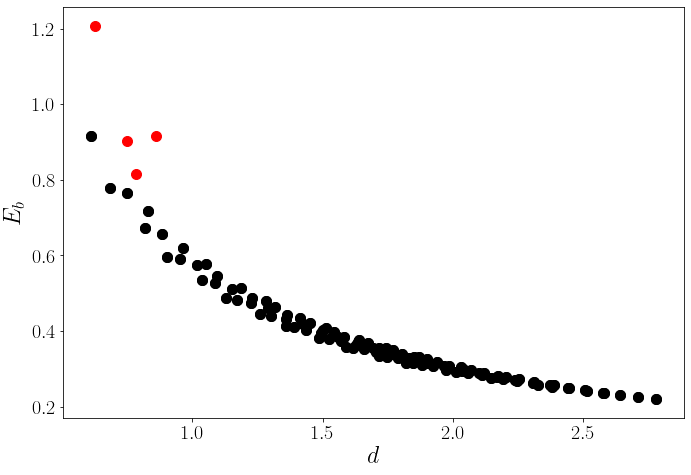

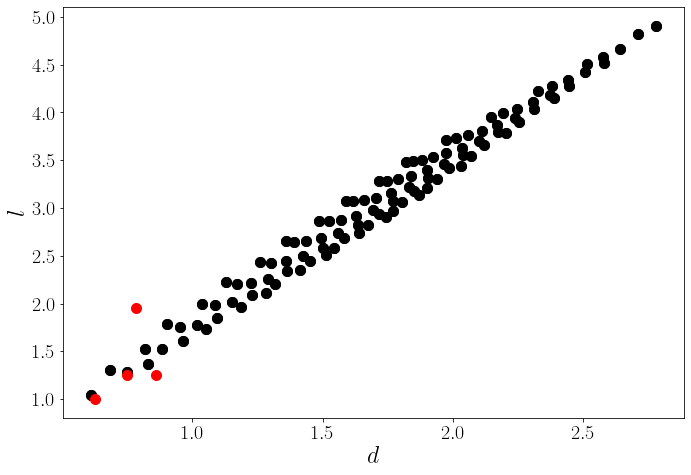

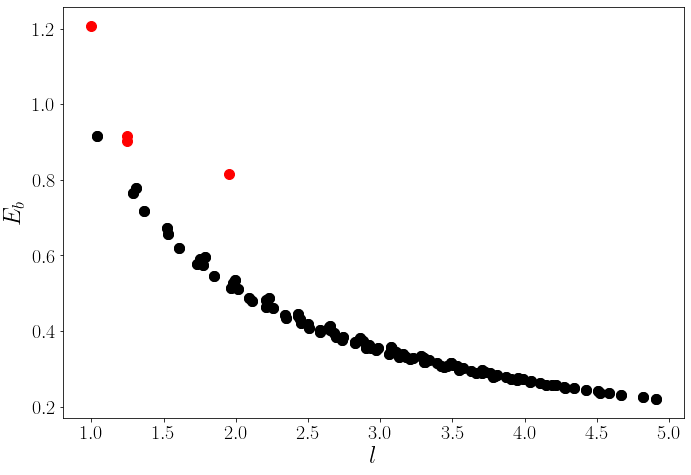

In [9]:
plt.figure()

my_data_x = [(8,0), (10,0), (11,0), (6,5)]
my_data_size = [1, 1.95, 1.25, 1.25]
my_data_Eb = [1.208, 0.816, 0.915, 0.902]

for n in range(4, 22):
    for m in range(4,22):
        if (2*n+m) % 3 != 0:
            plt.plot(ntc_diam(n,m), Eb_CapazPRB2006(n, m), 'ko')

for i in range(len(my_data_x)):
    m, n = my_data_x[i]
    d = ntc_diam(m, n)
    plt.plot([d], [my_data_Eb[i]], 'ro')            
            
plt.ylabel(r'$E_b$')
plt.xlabel(r'$d$')
            
plt.figure()

for n in range(4, 22):
    for m in range(4,22):
        if (2*n+m) % 3 != 0:
            plt.plot(ntc_diam(n,m), Exciton_size_CapazPRB2006(n, m), 'ko')
            
for i in range(len(my_data_x)):
    m, n = my_data_x[i]
    d = ntc_diam(m, n)
    plt.plot([d], [my_data_size[i]], 'ro')
    
    
plt.ylabel(r'$l$')
plt.xlabel(r'$d$')
            
plt.figure()

for n in range(4, 22):
    for m in range(4,22):
        if (2*n+m) % 3 != 0:
            plt.plot(Exciton_size_CapazPRB2006(n,m), Eb_CapazPRB2006(n, m), 'ko')

for i in range(len(my_data_x)):
    plt.plot([my_data_size[i]], [my_data_Eb[i]], 'ro')            
            
plt.ylabel(r'$E_b$')
plt.xlabel(r'$l$')

In [4]:
# parametros

dz = 1e-1
zmax = 200
z = np.arange(-zmax, zmax, dz)

Qeff = 0.3

alpha = 1.4399497301900483 # eV.nm -> valor de e^2/4pi*eps0*z para r=1nm
beta = 0.01904984875971439 # eV.nm^2 -> valor de hbar^2/(4*m_e0*l0^2), onde m_e0 eh a massa de repouso do eletron
                           # e l0 = 1nm - energia cinética do pacote gaussiano eh hbar/(4*mu*l0^2)


# massas
mh = 0.14776191224670518
me = 0.14625192772902104

#me, mh = 0.8 ,0.4

M = me + mh
mu = me*mh/M

In [5]:
def exciton_E11(z, l0):
    N = np.sqrt(l0)*(np.pi)**(0.25)   # normalizacao
    return (1/N)*np.exp(-z**2/(2*l0**2))

def exciton_imp(z, l0, Zcm, lcm):  # localizado na origem!
    N = np.sqrt(l0)*(np.pi)**(0.25)   # normalizacao
    N2 = np.sqrt(lcm)*(np.pi)**(0.25)
    ze = Zcm + mh/M*z
    return (1/(N*N2))*np.exp(-z**2/(2*l0**2))*np.exp(-ze**2/(2*lcm**2))

In [77]:
def energia_cinetica_exciton(l0):
    return beta/(l0**2*mu)   # mu = massa reduzida em unidades da massa de repouso do eletron (9.109e-31 kg)

def Ohno_e_h(U, z):
    return -U/np.sqrt(1 + (z*U/alpha)**2 )

def U_e(z, ZI, Zcm):
    Utemp = Ohno_e_h(0, z)  # criando array de 0 kkkkkk
    for zi in ZI:
        Utemp += Qeff*Ohno_e_h(U,  z*mh/M + Zcm - zi)
    return Utemp

def U_h(z, ZI, Zcm):
    Utemp = Ohno_e_h(0,  z)  # criando array de 0 kkkkkk
    for zi in ZI:
        Utemp += -Qeff*Ohno_e_h(U,  -z*me/M + Zcm - zi)
    return Utemp

def U_Tot(z, Qeff, ZI, Zcm):
    Utemp = Ohno_e_h(U,  z)
    for zi in ZI:
        Utemp += Qeff*Ohno_e_h(U,  z*mh/M + Zcm - zi)
        Utemp += -Qeff*Ohno_e_h(U,  -z*me/M + Zcm - zi)
    return Utemp

def Pot_integradoE11(l0):
    return sum(U_Tot(z, Qeff, ZI, Zcm)*exciton_E11(z, l0)**2*dz)

def Pot_ExImp(l0):
    return sum(U_Tot(z, Qeff, ZI, Zcm)*exciton_imp(z, l0, Zcm, lcm)**2*dz)

def TotEng_E11(l0):
    return Pot_integradoE11(l0) + energia_cinetica_exciton(l0)

def TotEng_Eimp(l0):
    return Pot_ExImp(l0) + energia_cinetica_exciton(l0)

def TotEng_E11_mod(l0, eps):
    return Pot_integradoE11(l0)/eps + energia_cinetica_exciton(l0)

In [75]:

# determinando L0 otimo para cada U

# U = 50 -> 0.18999999999999995 -15.648291326558864
# U = 0.5 -> 2.5399999999999987 -0.4004362027680573

L_OPT, EB_OPT = [], []

U_RANGE = np.arange(0.02, 10, 0.1)
ZI = []
Zcm = 0.0

L0 = np.arange(0.1, 5.5, 0.01)
for U in U_RANGE:
    TOTENG = []

    for l0 in L0:
        TOTENG.append(TotEng_E11(l0))

    plt.plot(L0, TOTENG)
    indmin = TOTENG.index(min(TOTENG))
    L_OPT.append(L0[indmin])
    EB_OPT.append(-min(TOTENG))
    #print(L0[indmin], min(TOTENG))

plt.ylim([min(TOTENG)*1.1, 0])
plt.grid()

TypeError: 'numpy.float64' object is not iterable

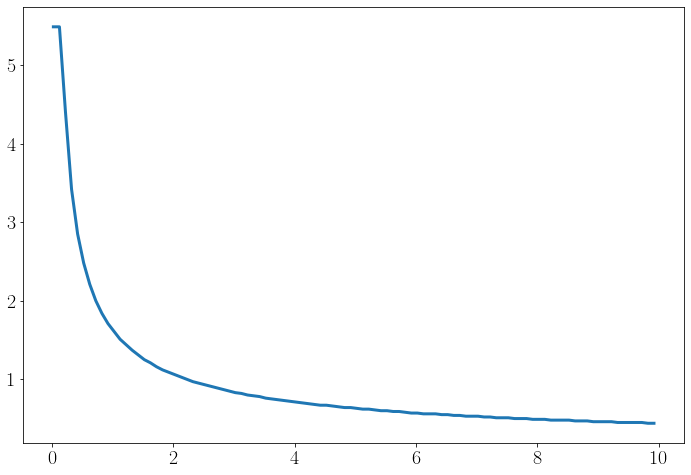

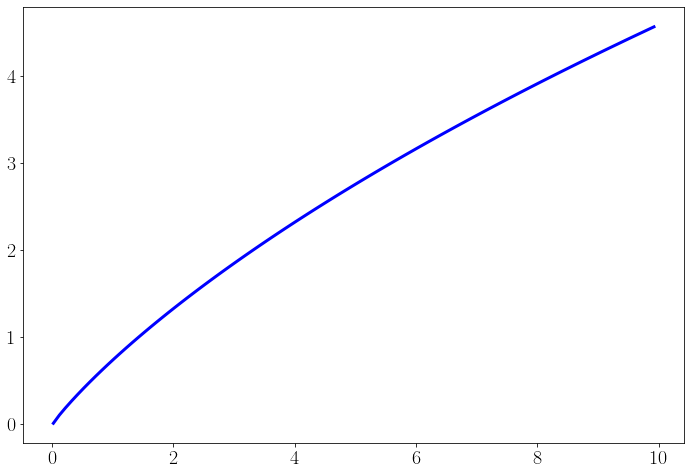

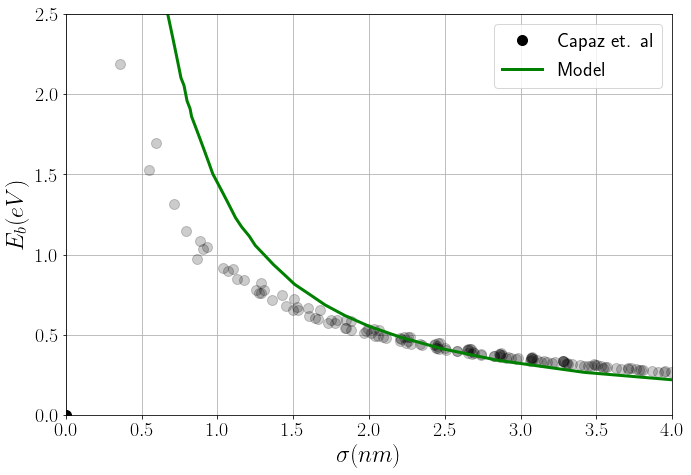

In [55]:
plt.figure()
plt.plot(U_RANGE, L_OPT)

plt.figure()
plt.plot(U_RANGE, EB_OPT, 'b')

plt.figure()

for n in range(1, 22):
    for m in range(0,n):
        if (2*n+m) % 3 != 0:
            plt.plot(Exciton_size_CapazPRB2006(n,m), Eb_CapazPRB2006(n, m), 'ko', alpha=0.2)
            
plt.plot([0], [0], 'ko', alpha=1, label='Capaz et. al')

plt.plot(L_OPT, EB_OPT, 'g', label='Model')
#plt.plot(L_BGW, Eb_BGW, 'ro', label='Ab initio data')            
plt.xlabel(r'$\sigma (nm)$')
plt.ylabel(r'$E_b (eV)$')

plt.grid()            
plt.xlim([0, 4.0])
plt.ylim([0, 2.5])
plt.legend()

In [9]:
# Um defeito na origem

U = 3.0
ZI = []
Zcm = 0
x0 = np.array([0.2])
res = minimize(TotEng_E11, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
l0_opt_free = res.x[0]
Eb_free = TotEng_E11(l0_opt_free)

ZI = [0.0]

Zmax = 5
ZCM = np.linspace(-Zmax, Zmax, 200)
Eb_vs_ZCM = []
L0_vs_ZCM = []

for Zcm in ZCM:
#    TotEng_E11(l0)
    x0 = np.array([0.2])
    res = minimize(TotEng_E11, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    l0_opt = res.x[0]
    
    L0_vs_ZCM.append(l0_opt)
    Eb_vs_ZCM.append(TotEng_E11(l0_opt))
    

Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.850725
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850725
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.850725
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.850725
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.850725
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850726
         Iterations: 31
         Function evaluations: 63
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850805
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850812
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850819
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850826
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850835
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850844
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850854
         Iterations: 31
         Function evaluations: 63
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.851123
         Iterations: 32
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -1.851108
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.851089
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851067
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851044
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.851021
         Iterations: 32
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -1.850999
         Iterations: 31
         Function evaluations: 62
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850731
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.850730
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850730
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850730
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850729
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850729
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850728
         Iterations: 32
         Function evaluations: 65
Optimization terminated suc

Text(0.5, 0, '$Z_{CM}(nm)$')

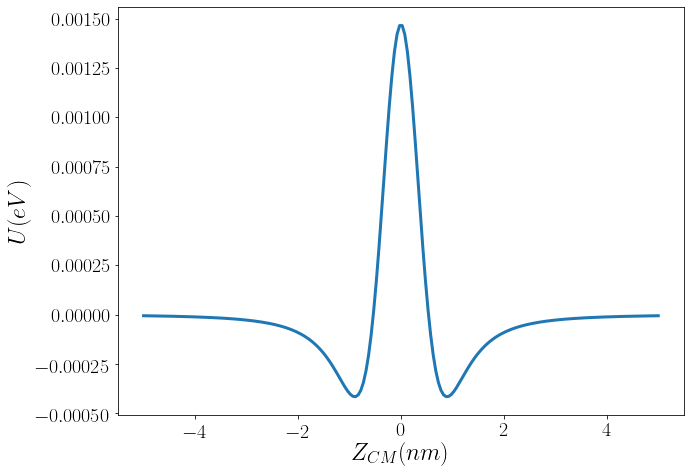

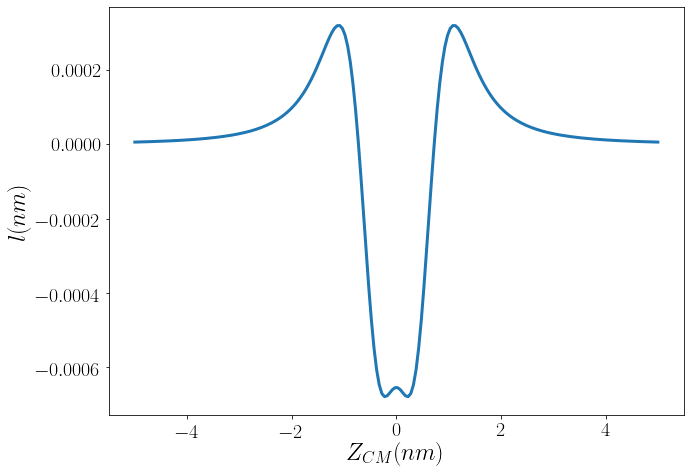

In [10]:
plt.figure()
plt.plot(ZCM, np.array(Eb_vs_ZCM)-Eb_free)

plt.ylabel(r'$U(eV)$')
plt.xlabel(r'$Z_{CM}(nm)$')


plt.figure()
plt.plot(ZCM, np.array(L0_vs_ZCM)-l0_opt_free)
plt.ylabel(r'$l(nm)$')
plt.xlabel(r'$Z_{CM}(nm)$')



In [11]:
# rede de defeitos

# Um defeito na origem

U = 3.0
ZI = []
x0 = np.array([0.2])
res = minimize(TotEng_E11, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
l0_opt_free = res.x[0]
Eb_free = TotEng_E11(l0_opt_free)

dZCM = 1
Zmax = 100
ZCM = np.linspace(-Zmax, Zmax, int(2*Zmax/dZCM))

LATT = [0.42, 1.6, 4.2, 10]

Eb_vs_ZCM_LATT = []
L0_vs_ZCM_LATT = []

for latt in LATT:
    
    Eb_vs_ZCM = []
    L0_vs_ZCM = []

    ZI = []
    Ncells = int(1.2*Zmax/latt)
    for i in range(-Ncells, Ncells + 1):
        ZI.append(latt*i)

    for Zcm in ZCM:
    #    TotEng_E11(l0)
        x0 = np.array([0.2])
        res = minimize(TotEng_E11, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
        l0_opt = res.x[0]

        L0_vs_ZCM.append(l0_opt)
        Eb_vs_ZCM.append(TotEng_E11(l0_opt))
        
    Eb_vs_ZCM_LATT.append(Eb_vs_ZCM)
    L0_vs_ZCM_LATT.append(L0_vs_ZCM_LATT)
    

Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.850716
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850716
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850716
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850717
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850717
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850717
         Iterations: 31
         Function evaluations: 63
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 63
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850718
         Iterations: 31
         Function evaluations: 62
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.851659
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.849951
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850831
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.851405
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.849658
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851424
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850800
         Iterations: 31
         Function evaluations: 62
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.851632
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850288
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850446
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851587
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.849738
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.851150
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851150
         Iterations: 32
         Function evaluations: 64
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.851494
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850673
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850081
         Iterations: 32
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -1.851661
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.849975
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850800
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851424
         Iterations: 31
         Function evaluations: 62
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.849803
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.851045
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850892
         Iterations: 32
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -1.851166
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.849330
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851121
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850886
         Iterations: 31
         Function evaluations: 62
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.851117
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850909
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850983
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850413
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.850847
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850942
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850935
         Iterations: 31
         Function evaluations: 63
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.851051
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850891
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.851164
         Iterations: 32
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -1.849315
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851126
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850886
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.851109
         Iterations: 31
         Function evaluations: 63
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850910
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850979
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850454
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850818
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850945
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850932
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850937
         Iterations: 32
         Function evaluations: 66
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850851
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851087
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.849748
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851012
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850785
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850744
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850733
         Iterations: 32
         Function evaluations: 65
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850771
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850932
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850469
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850763
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850900
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850766
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850739
         Iterations: 31
         Function evaluations: 64
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -1.850746
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850794
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.851058
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.849445
         Iterations: 31
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -1.851134
         Iterations: 31
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -1.850833
         Iterations: 31
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -1.850754
         Iterations: 31
         Function evaluations: 63
Optimization terminated suc

(-10, 10)

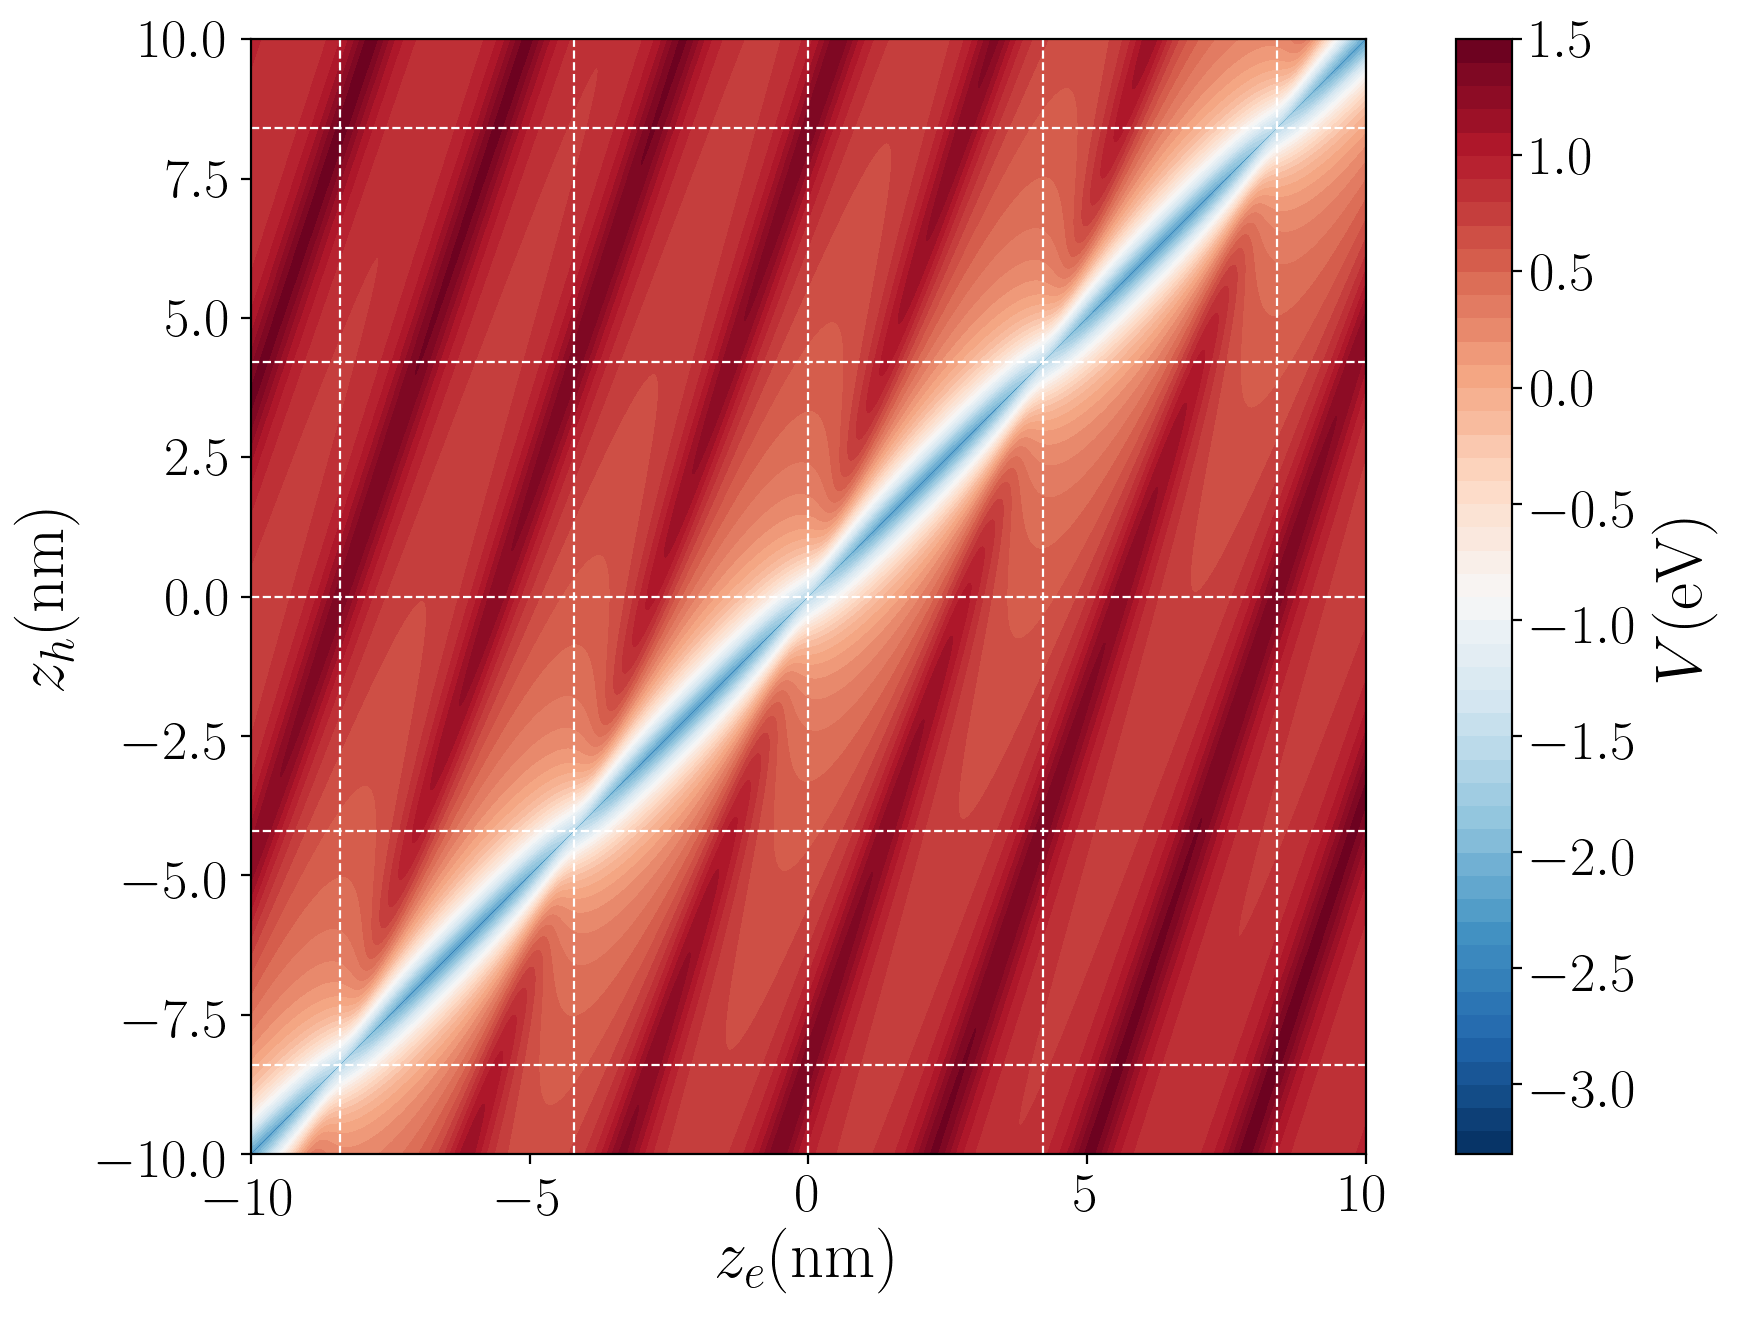

In [177]:

mh = 0.14776191224670518
me = 1000.14625192772902104
Qeff = -0.3

tempz, tempU = [], []

#me ,mh = 0.6, 0.6



Zplotmax = 10

dz2 = dz/10
ZE = np.arange(-Zplotmax, Zplotmax + dz2, dz2)
ZH = np.arange(-Zplotmax, Zplotmax + dz2, dz2)
U = 3.0

ZI = []
latt = 0.42*10
Ncells = int(Zplotmax/latt)+10
for i in range(-Ncells, Ncells + 1):
    ZI.append(i*latt)

# A = 5*0.42
# ZI = [-A, A]
# ZI = [0]

PotU_2D = np.zeros( (len(ZE), len(ZH)) )

for i in range(len(ZE)):
    ze = ZE[i]
    for j in range(len(ZH)):
        zh = ZH[j]
        Zcm = (me*ze+mh*zh)/(me+mh)
        z = ze - zh
        PotU_2D[j][i] = U_Tot(z, Qeff, ZI, Zcm)
        
        if ze == zh:
            tempz.append(ze)
            tempU.append(PotU_2D[j][i])

#plt.figure(figsize=(8, 8))
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

Nlevels = 50
#plt.contour(ZE, ZH, PotU_2D, levels=Nlevels, linewidths=0.5, colors='k')
CS = ax.contourf(ZE, ZH, PotU_2D, levels=Nlevels, cmap="RdBu_r")
# plt.plot(ZE, ZE, 'w--', linewidth=0.8)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel(r'$V ( \mathrm{eV} ) $')
plt.xlabel(r'$z_e(\mathrm{nm})$')
plt.ylabel(r'$z_h(\mathrm{nm})$')

for i in range(len(ZI)):
    plt.plot([ZI[i], ZI[i]], [-Zplotmax, Zplotmax], 'w--', linewidth=0.8)
    plt.plot([-Zplotmax, Zplotmax], [ZI[i], ZI[i]], 'w--', linewidth=0.8)
    
plt.xlim([-Zplotmax, Zplotmax])
plt.ylim([-Zplotmax, Zplotmax])

Text(0.5, 0, '$Z_{CM}(\\mathrm{eV})$')

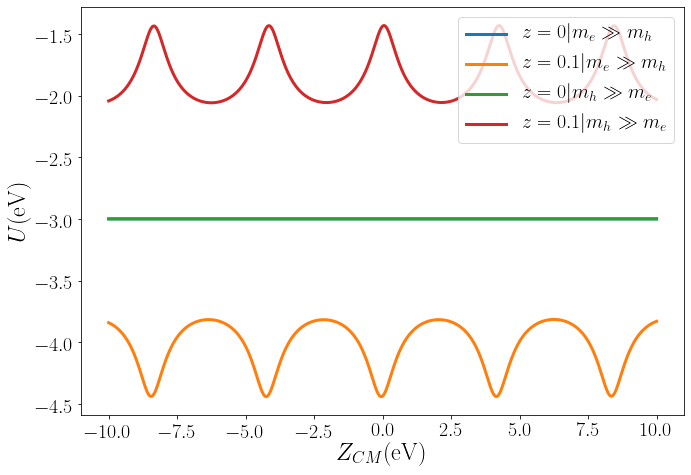

In [178]:
mh = 0.14776191224670518
me = 1000.14625192772902104
Qeff = 0.3
plt.figure()

tempz, tempU = [], []
tempz2, tempU2 = [], []
for i in range(len(ZE)):
    ze = ZE[i]
    zh = ZE[i]
    Zcm = (me*ze+mh*zh)/(me+mh)
    z = ze - zh + 0
     
    tempz.append(ze)
    tempU.append(U_Tot(z, Qeff, ZI, Zcm))
    
    z = ze - zh + 0.1
    tempz2.append(ze)
    tempU2.append(U_Tot(z, Qeff, ZI, Zcm))

plt.plot(tempz, tempU, label=r'$z = 0 | m_e \gg m_h $')
plt.plot(tempz2, tempU2, label=r'$z = 0.1 | m_e \gg m_h $')

mh = 1000.14776191224670518
me = 0.14625192772902104

tempz, tempU = [], []
tempz2, tempU2 = [], []
for i in range(len(ZE)):
    ze = ZE[i]
    zh = ZE[i]
    Zcm = (me*ze+mh*zh)/(me+mh)
    z = ze - zh + 0
     
    tempz.append(ze)
    tempU.append(U_Tot(z, Qeff, ZI, Zcm))
    
    z = ze - zh + 0.1
    tempz2.append(ze)
    tempU2.append(U_Tot(z, Qeff, ZI, Zcm))

plt.plot(tempz, tempU, label=r'$z = 0 | m_h \gg m_e $')
plt.plot(tempz2, tempU2, label=r'$z = 0.1 | m_h \gg m_e $')
    
plt.legend()
plt.ylabel(r'$U(\mathrm{eV})$')
plt.xlabel(r'$Z_{CM}(\mathrm{eV})$')

(-5.0, 5.0)

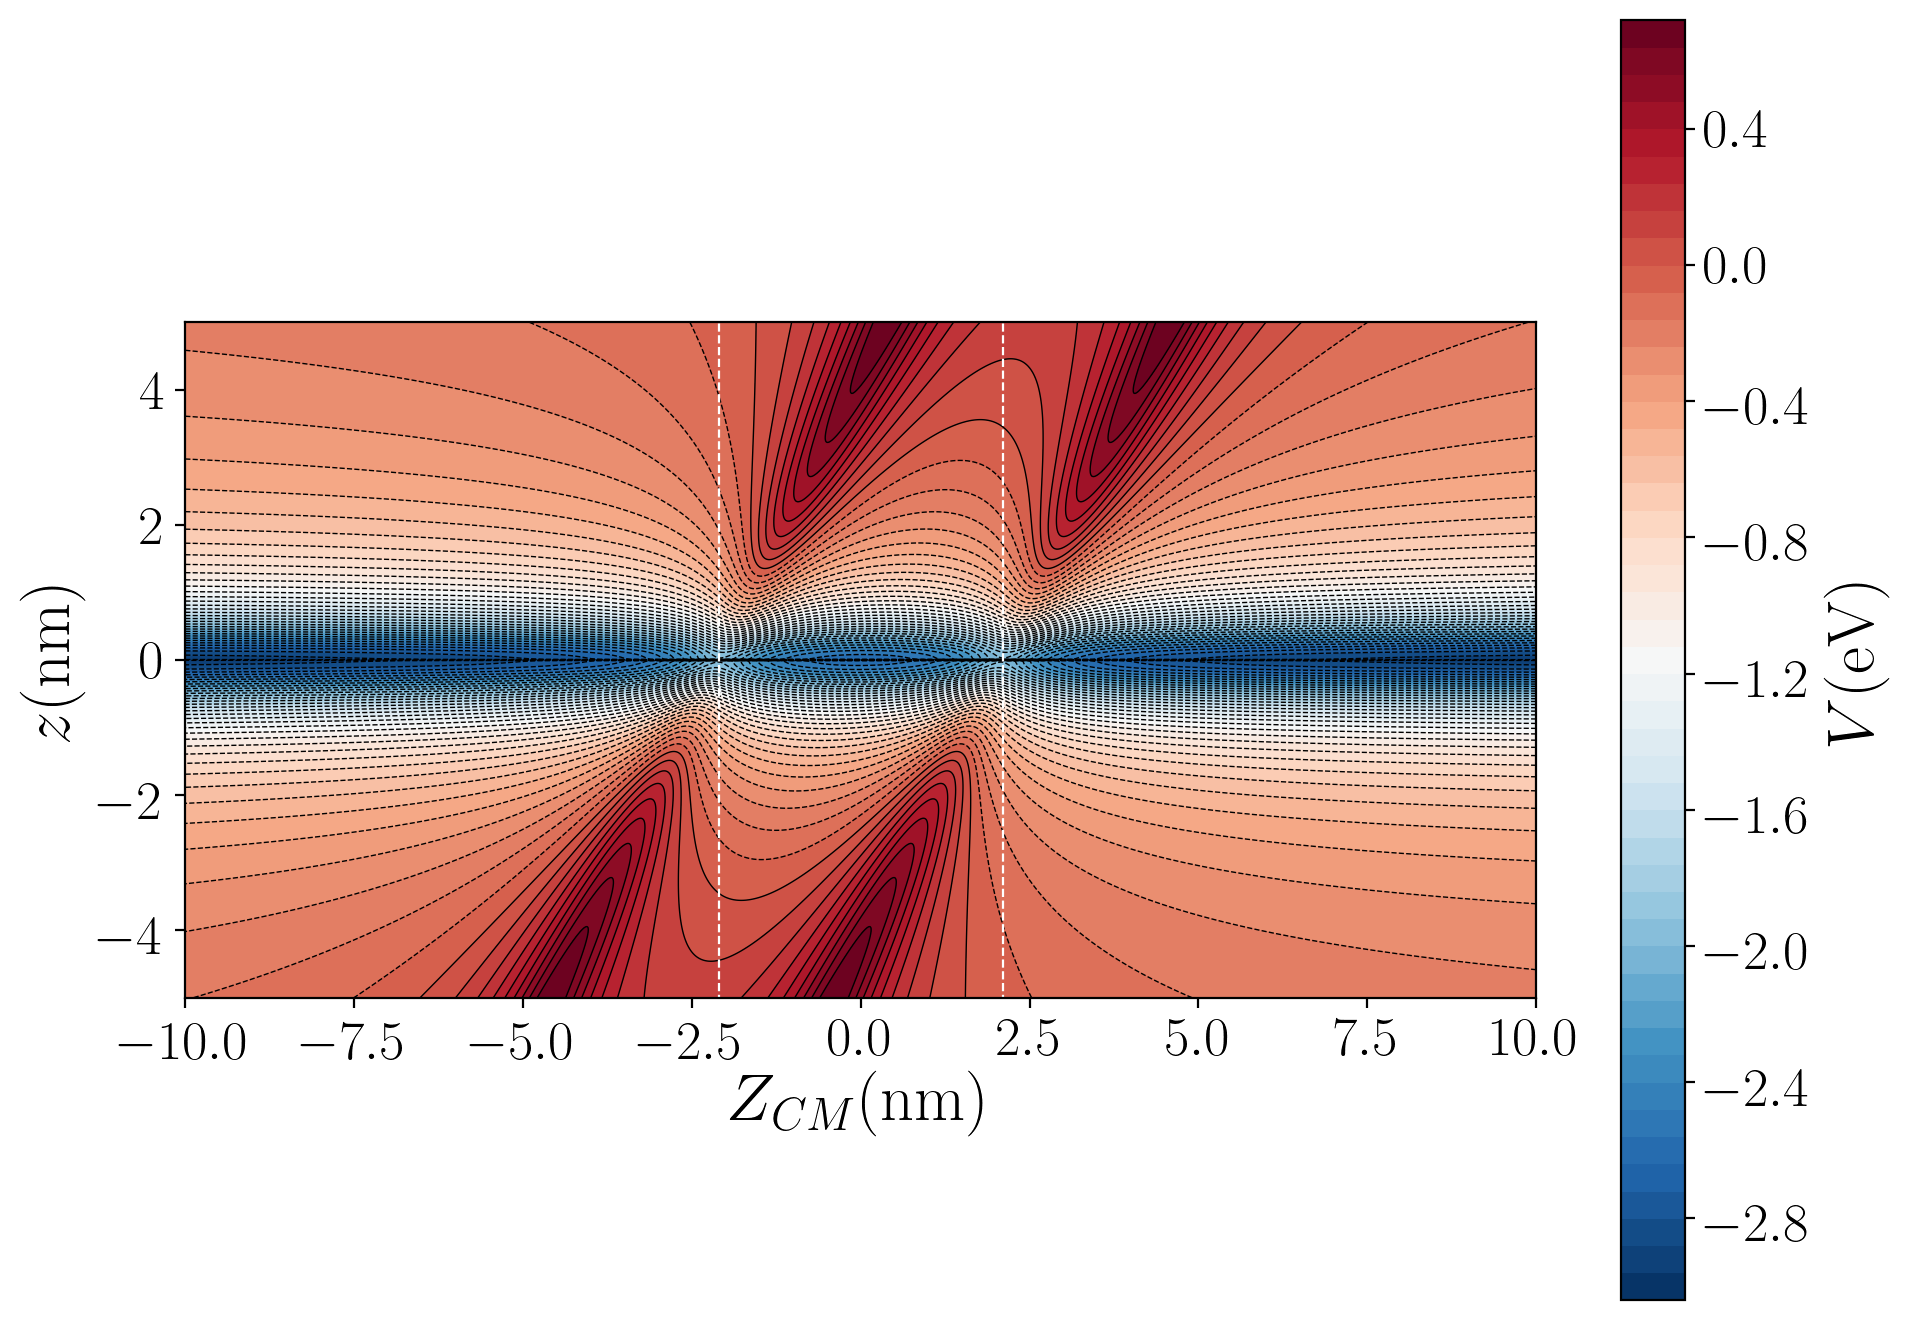

In [181]:

mh = 1000.14776191224670518
me = 0.14625192772902104

#me ,mh = 0.6, 0.6

Qeff = 0.3

Zplotmax = 10

factor = 2
dz2 = dz/10
Z = np.arange(-Zplotmax/factor, Zplotmax/factor + dz2, dz2)
ZCM = np.arange(-Zplotmax, Zplotmax + dz2, dz2)
U = 3.0

ZI = []
latt = 10*0.42
Ncells = int(Zplotmax/latt)+2
for i in range(-Ncells, Ncells + 1):
    ZI.append(i*latt)

A = 0.42*5
ZI = [-A, A]
#ZI = [0.0]

PotU_2D = np.zeros( (len(Z), len(ZCM)) )

for i in range(len(Z)):
    z = Z[i]
    for j in range(len(ZCM)):
        Zcm = ZCM[j]
        PotU_2D[i][j] = U_Tot(z, Qeff, ZI, Zcm)

#plt.figure(figsize=(8, 8))
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

Nlevels = 50
plt.contour(ZCM, Z, PotU_2D, levels=Nlevels, linewidths=0.5, colors='k')
CS = ax.contourf(ZCM, Z, PotU_2D, levels=Nlevels, cmap="RdBu_r")
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel(r'$V ( \mathrm{eV} ) $')
plt.ylabel(r'$z(\mathrm{nm})$')
plt.xlabel(r'$Z_{CM}(\mathrm{nm})$')

for i in range(len(ZI)):
    plt.plot([ZI[i], ZI[i]], [-Zplotmax, Zplotmax], 'w--', linewidth=0.8)
    
plt.xlim([-Zplotmax, Zplotmax])
plt.ylim([-Zplotmax/factor, Zplotmax/factor])

(-5.0, 5.0)

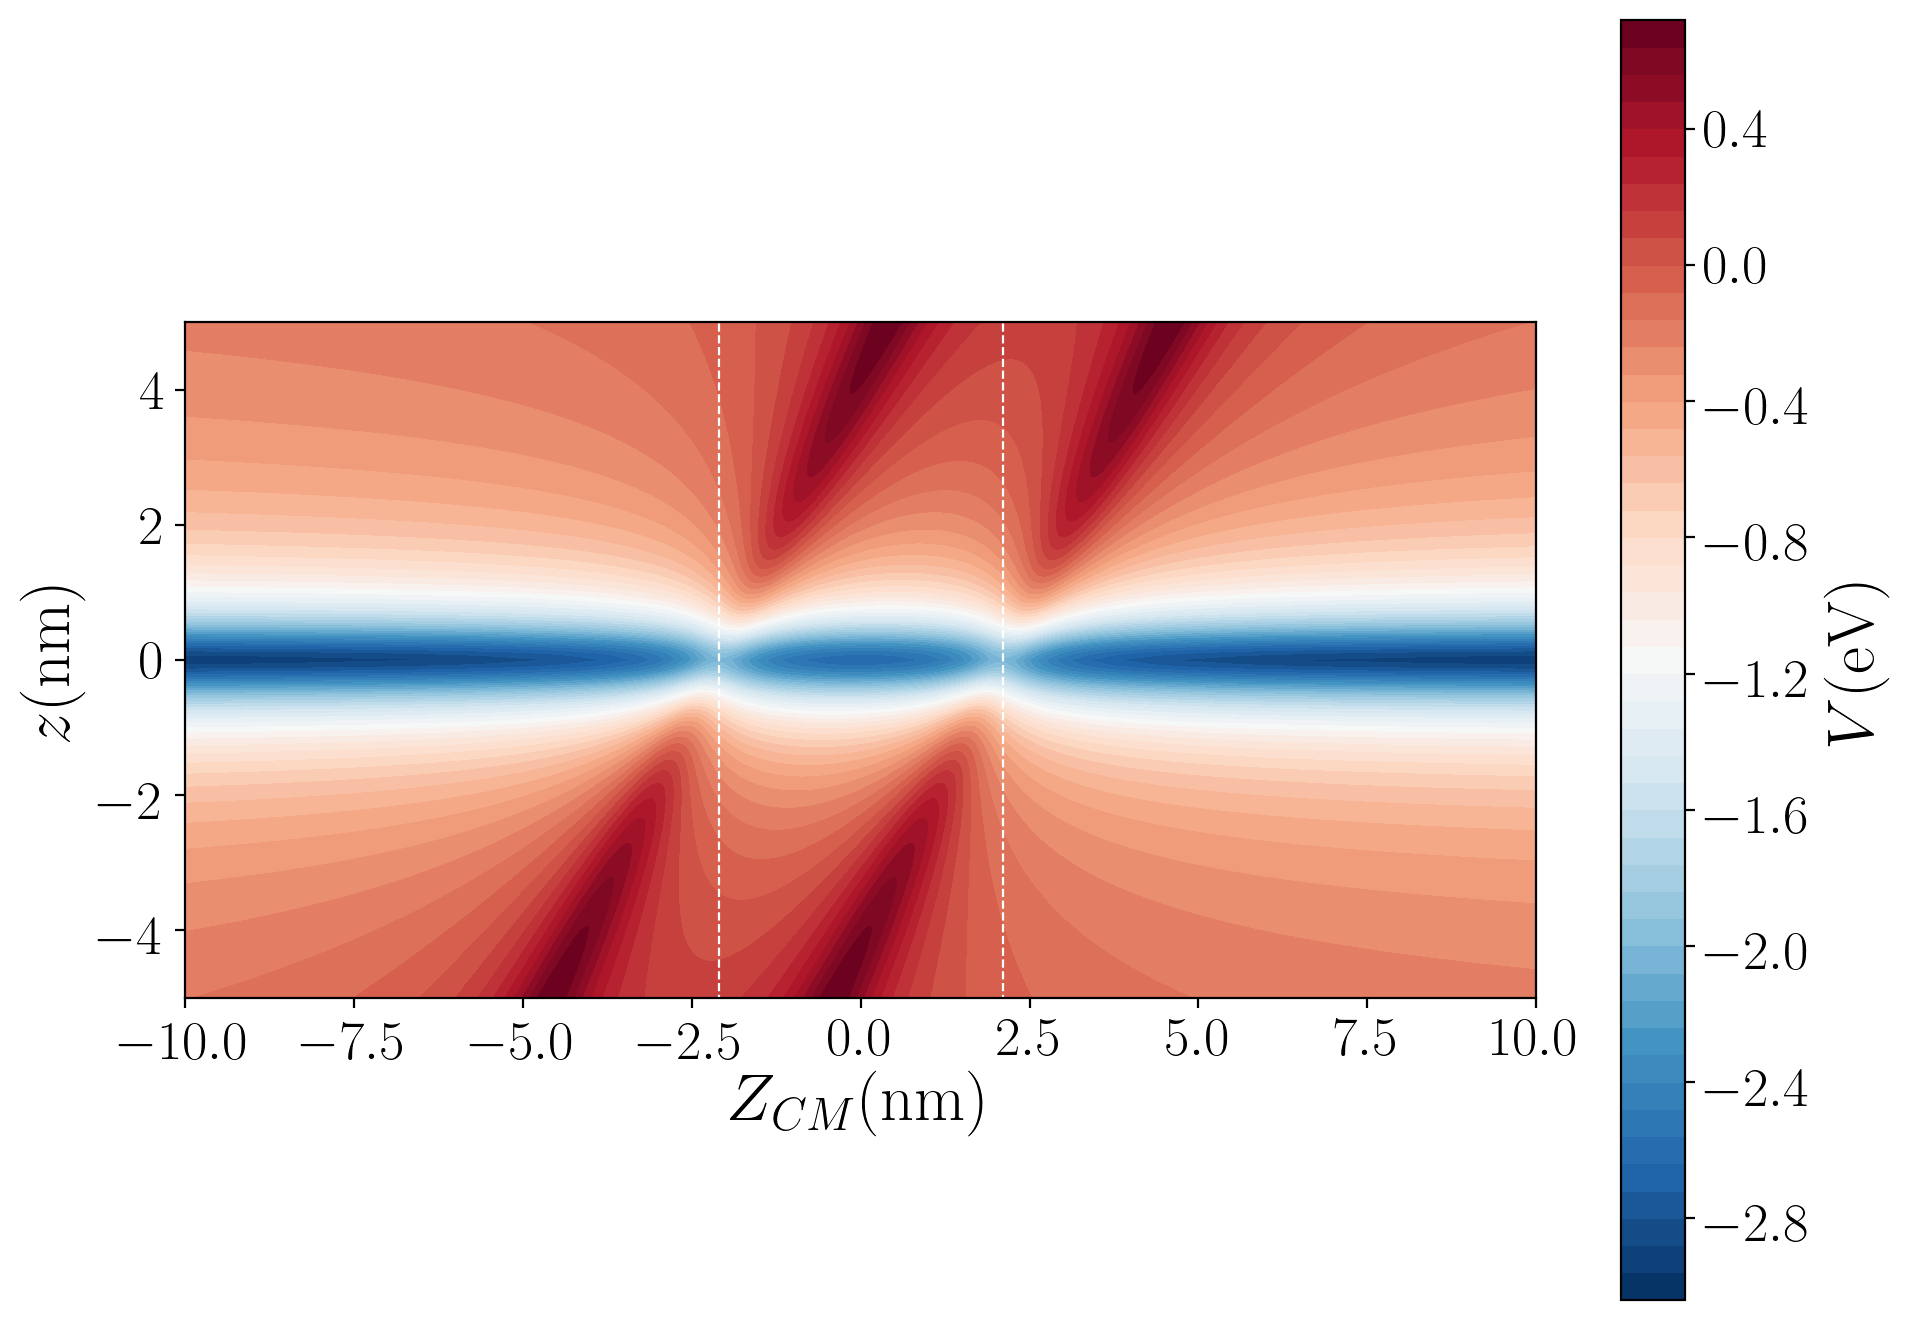

In [182]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

Nlevels = 50
#plt.contour(ZCM, Z, PotU_2D, levels=Nlevels, linewidths=0.5, colors='k')
CS = ax.contourf(ZCM, Z, PotU_2D, levels=Nlevels, cmap="RdBu_r")
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel(r'$V ( \mathrm{eV} ) $')
plt.ylabel(r'$z(\mathrm{nm})$')
plt.xlabel(r'$Z_{CM}(\mathrm{nm})$')

for i in range(len(ZI)):
    plt.plot([ZI[i], ZI[i]], [-Zplotmax, Zplotmax], 'w--', linewidth=0.8)
    
plt.xlim([-Zplotmax, Zplotmax])
plt.ylim([-Zplotmax/factor, Zplotmax/factor])

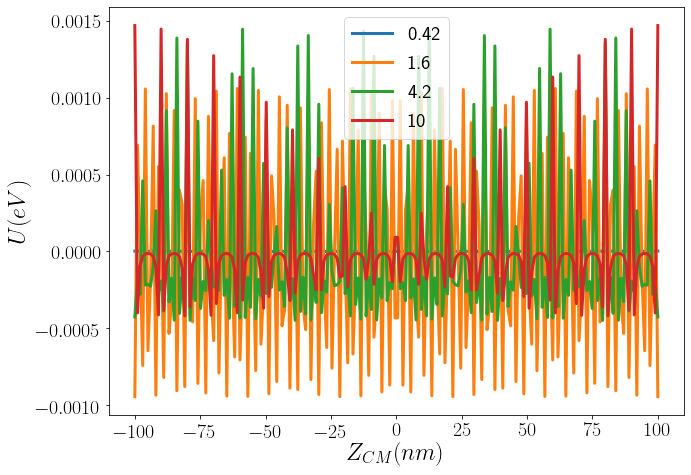

In [12]:
plt.figure()

for i in range(len(LATT)):
    plt.plot(ZCM, np.array(Eb_vs_ZCM_LATT[i])-Eb_free, label=str(LATT[i]))

plt.ylabel(r'$U(eV)$')
plt.xlabel(r'$Z_{CM}(nm)$')
plt.legend()


In [88]:
# exciton E-

mh = 0.14776191224670518
me = 10000 #0.14625192772902104
mu = me*mh/(me+mh)
M = me + mh

Qeff = -0.3


# Um defeito na origem

ZI = [0.0]

Zmax = 5
ZCM = np.linspace(-Zmax, Zmax, 50)

lcm = 1.0
LCM = [0.5, 1.0, 2.0, 5.0]
Eb_vs_ZCM_IMP_LCM = []

U = 3.0

for lcm in LCM:
    ZI = []
    Zcm = 0
    x0 = np.array([0.2])
    res = minimize(TotEng_Eimp, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    l0_opt_free = res.x[0]
    Eb_free = TotEng_E11(l0_opt_free)


    Eb_vs_ZCM_IMP = []
    L0_vs_ZCM_IMP = []

    for Zcm in ZCM:
    #    TotEng_E11(l0)
        x0 = np.array([l0_opt_free])
        res = minimize(TotEng_Eimp, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
        l0_opt = res.x[0]

#         Eb_vs_ZCM_IMP.append(TotEng_Eimp(l0_opt_free))
        Eb_vs_ZCM_IMP.append(TotEng_Eimp(l0_opt))
        
    Eb_vs_ZCM_IMP_LCM.append(Eb_vs_ZCM_IMP)
    

Optimization terminated successfully.
         Current function value: -2.405711
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 75
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 64
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 55
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.000002
         Iterations: 48
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.000114
         Iterations: 42
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -0.002816
         Iterations: 37
         Function evaluations: 77
Optimization terminated

Optimization terminated successfully.
         Current function value: -0.956845
         Iterations: 23
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -1.056937
         Iterations: 23
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -1.056937
         Iterations: 23
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -0.956845
         Iterations: 23
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: -0.783065
         Iterations: 24
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: -0.577573
         Iterations: 26
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.382090
         Iterations: 28
         Function evaluations: 56
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -0.138485
         Iterations: 29
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -0.105025
         Iterations: 30
         Function evaluations: 62
Optimization terminated successfully.
         Current function value: -0.077138
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.054798
         Iterations: 32
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.037601
         Iterations: 32
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.024885
         Iterations: 33
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: -0.015862
         Iterations: 35
         Function evaluations: 73
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -0.072121
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -0.066455
         Iterations: 29
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: -0.060935
         Iterations: 30
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -0.055598
         Iterations: 30
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: -0.050476
         Iterations: 30
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: -0.045593
         Iterations: 30
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: -0.040972
         Iterations: 32
         Function evaluations: 66
Optimization terminated suc

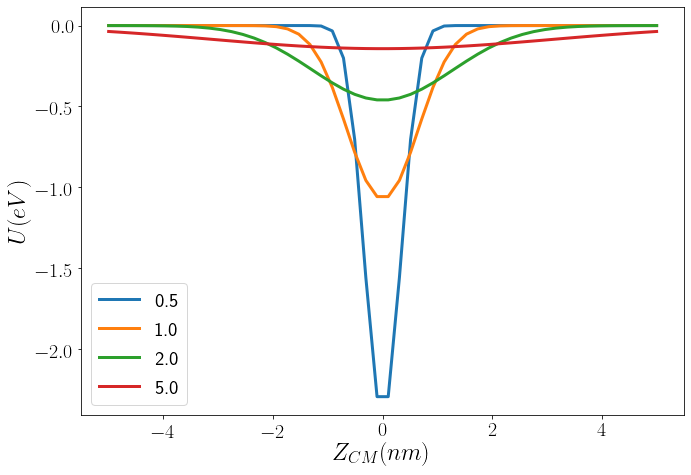

In [90]:
plt.figure()

for i in range(len(Eb_vs_ZCM_IMP_LCM)):
    plt.plot(ZCM, np.array(Eb_vs_ZCM_IMP_LCM[i]), label=str(LCM[i]))

plt.ylabel(r'$U(eV)$')
plt.xlabel(r'$Z_{CM}(nm)$')
plt.legend()

In [121]:
# exciton E-

mh = 0.14776191224670518
me = 10000 #0.14625192772902104
mu = me*mh/(me+mh)
M = me + mh
Qeff = -0.3

# Um defeito na origem

lcm = 3

U = 2.0
ZI = []
Zcm = 0
x0 = np.array([0.2])
res = minimize(TotEng_Eimp, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
l0_opt_free = res.x[0]
Eb_free = TotEng_E11(l0_opt_free)


latt = 2

ZI = []
Ncells = int(1.2*Zmax/latt)
for i in range(-Ncells, Ncells + 1):
    ZI.append(latt*i)

Zmax = 10
ZCM = np.linspace(-Zmax, Zmax, 200)
Eb_vs_ZCM_IMP = []
L0_vs_ZCM_IMP = []

LATT = [0.42, 1.6, 4.2, 10]

Eb_vs_ZCM_LATT = []
L0_vs_ZCM_LATT = []

for latt in LATT:
    
    Eb_vs_ZCM = []
    L0_vs_ZCM = []

    ZI = []
    Ncells = int(1.2*Zmax/latt)
    for i in range(-Ncells, Ncells + 1):
        ZI.append(latt*i)

    for Zcm in ZCM:
    #    TotEng_E11(l0)

        Eb_vs_ZCM.append(TotEng_Eimp(l0_opt_free))
        
    Eb_vs_ZCM_LATT.append(Eb_vs_ZCM)
    
    

Optimization terminated successfully.
         Current function value: -0.204816
         Iterations: 33
         Function evaluations: 68


-0.20296478418578434
-0.20069702053054717
-0.1861550717043054
-0.18222698145566968


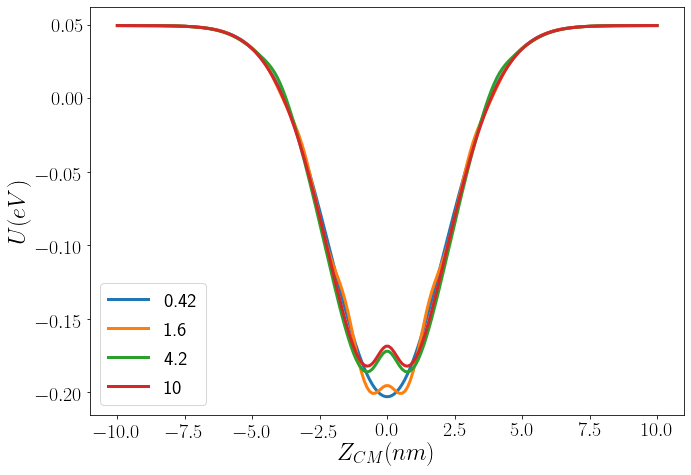

In [122]:
plt.figure()

for i in range(len(LATT)):
    plt.plot(ZCM, np.array(Eb_vs_ZCM_LATT[i]), label=str(LATT[i]))
    print(min(Eb_vs_ZCM_LATT[i]))

plt.ylabel(r'$U(eV)$')
plt.xlabel(r'$Z_{CM}(nm)$')
plt.legend()

# MIN = [-1.0703661860417242, -1.144039135457029, -1.1841255506478738, -1.1864538512478995]
# plt.figure()
# plt.plot(LATT, MIN)

#plt.ylim([-1.2, -1])